# Project Master Script 2

# Part 3: Classifier interpretability

In this **master script 2**, we integrate all the contents in part 3 described in guideline, including:

1. Load the CIFAR-10 datasets
2. Train a decision tree to classify images on CIFAR-10 datsets
3. Interpret the decision tree by plotting
4. Train a convolutional neural network (CNN) classifier using PyTorch to classify images on CIFAR-10 datasets
5. Interpret the CNN by using the 'activation maximization' technique


<div style="border-bottom: 3px solid black;"><div>

# 0. Import packages

In [1]:
import os
import numpy as np
import pickle
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sklearn
import sklearn.tree
import sklearn.metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from PIL import Image

# 1. Load the CIFAR-10 datasets

We use *torchvision.datasets.CIFAR10* to load the local CIFAR-10 datasets by setting `download=False`

This function is cited from torchvision.datasets documentation.

*Reference and credit: https://pytorch.org/docs/stable/torchvision/datasets.html*

In [45]:
def load_CIFAR10(root='datasets/'):
    
    transform = transforms.Compose([  
        transforms.ToTensor(),
        
        # normalize values from [0, 1] to [-1, 1]
        transforms.Normalize(
            mean=(0.5, 0.5, 0.5), 
            std=(0.5, 0.5, 0.5)),
        
        # random erasing
        transforms.RandomErasing(),
    ])
    
    # read the training set by batches
    train_set = CIFAR10(root=root, train=True, download=False, transform=transform)
    train_loader = DataLoader(train_set, batch_size=5, shuffle=True, num_workers=2)
    
    # read the testing set by batches
    test_set = CIFAR10(root=root, train=False, download=False, transform=transform)
    test_loader = DataLoader(test_set, batch_size=5, shuffle=False, num_workers=2)
    
    return train_loader, test_loader



# Get the train_loader and test_loader
train_loader, test_loader = load_CIFAR10()


<div style="border-bottom: 3px solid black;"><div>

# 2. Train a decision tree to classify images on CIFAR10 datsets

In this and next section, we will train a basic decision tree classifier on CIFAR-10 datasets by applying GridSearch. Then we are going to plot the best estimator for the top few layers.

## 2.1 Define the decision_tree_CIFAR class

In [5]:
class decision_tree_CIFAR:
    
    def __init__(self):
        """
        constructor to read datasets into numpy array
        """
        # First, read the training batches
        # the folder path where it stores the CIFAR-10 training batches files
        cifar_path = 'datasets/cifar-10-batches-py'
        
        # file names for training batches
        training_batches = ('data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5')
        
        # temporary variables for reading files
        train_data = None
        train_labels = None
        
        for filename in training_batches:
            # read the file contents
            dict_train = self.unpickle(cifar_path, filename)
            file_data = dict_train[b'data']
            file_labels = dict_train[b'labels']
            
            # append the file contents in each batch to train_data and train_labels
            if train_data is None and train_labels is None:
                # for the first training batch
                train_data = file_data
                train_labels = file_labels
            else:
                # for the following training batches
                train_data = np.vstack((train_data, file_data))
                train_labels = np.hstack((train_labels, file_labels))
        self.x_train = train_data      # (50000, 3072)
        self.y_train = train_labels    # (50000,)
        
        # Second, read test batch file
        # file name for test batch
        test_batch = 'test_batch'
        
        # read the file contents
        dict_test = self.unpickle(cifar_path, test_batch)
        
        self.x_test = dict_test[b'data']      # (10000, 3072)
        self.y_test = dict_test[b'labels']    # (10000,)
    
    
    def unpickle(self, filepath, filename):
        """
        read the file and return the file contents
        
        @param filepath: file relative path
        @param filename: file name
        """
        with open(os.path.join(filepath, filename), 'rb') as fo:
            file = pickle.load(fo, encoding='bytes')
        return file
    
    
    ##################### Model training #####################
    def decision_tree_classifier(self, max_depth):
        """
        apply grid search on decision tree classifier with depth
        
        @param max_depth : max_depth of decision tree classifier
        
        @return return the best classifier
        """
        # normalize the training and testing data
        train_data_norm = self.x_train / 255.0
        
        # define a decision tree classifier model
        dtc = DecisionTreeClassifier(random_state=0)
        
        # define parameters range
        param_grid = {
            'max_depth': max_depth,
            'criterion': ('gini', 'entropy')
        }

        # apply grid search cross validation
        gridcv = GridSearchCV(
            estimator=dtc, 
            cv=3,    # 3-fold cross-validation
            n_jobs=4,    # use 4 processors to train
            param_grid=param_grid)
        gridcv.fit(train_data_norm, self.y_train)

        # save the best decision tree classifier
        self.best_dtc = gridcv.best_estimator_
        
        return self.best_dtc

## 2.2 Train the model

For selecting the best decision tree classifier in a reasonable time, we do cross validation over the hyper-parameters: `criterion` and `max_depth`, and here is our searching strategy:

1. Apply GridSearch over `criterion = ('gini', 'entropy')` and `max_depth = (2, 4, 8, 16)`, find the *gridcv_best_estimator* with optimal criterion and max_depth

2. Plot the top few layers of *gridcv_best_estimator*

**Attention!**

Step $1$ (the cell just below) may **need around 8 ~ 9 minutes** on the lab Linux environment


In [6]:
# Cross validate over 6 decision models with depth 2, 4, 8, 16
# define a model class
dt_cifar = decision_tree_CIFAR()

# define the max_depth ranges
max_depth = np.logspace(start=1, stop=4, base=2, num=4, dtype=np.int)

# retrieve the best model after grid search
gridcv_best_estimator = dt_cifar.decision_tree_classifier(max_depth=max_depth)

**Print the performance of best grid search estimator:**

In [7]:
# normalize the training and testing data
x_train_norm = dt_cifar.x_train / 255.0
x_test_norm = dt_cifar.x_test / 255.0

# print the performance
print('Best GridSearch estimator: ', gridcv_best_estimator)
print('Accuracy on the 50000 train images: %.2f %%' 
      % (100 * gridcv_best_estimator.score(X=x_train_norm, y=dt_cifar.y_train)))
print('Accuracy on the 10000 test images: %.2f %%' 
      % (100 * gridcv_best_estimator.score(X=x_test_norm, y=dt_cifar.y_test)))
print("Recall (average='micro') on the 50000 train images: %.3f" 
      % (recall_score(y_true=dt_cifar.y_train, y_pred=gridcv_best_estimator.predict(x_train_norm), average='micro')))
print("Recall (average='micro') on the 10000 test images: %.3f" 
      % (recall_score(y_true=dt_cifar.y_test, y_pred=gridcv_best_estimator.predict(x_test_norm), average='micro')))
print("Recall (average='macro') on the 50000 train images: %.3f" 
      % (recall_score(y_true=dt_cifar.y_train, y_pred=gridcv_best_estimator.predict(x_train_norm), average='macro')))
print("Recall (average='macro') on the 10000 test images: %.3f" 
      % (recall_score(y_true=dt_cifar.y_test, y_pred=gridcv_best_estimator.predict(x_test_norm), average='macro')))

Best GridSearch estimator:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
Accuracy on the 50000 train images: 34.96 %
Accuracy on the 10000 test images: 30.26 %
Recall (average='micro') on the 50000 train images: 0.350
Recall (average='micro') on the 10000 test images: 0.303
Recall (average='macro') on the 50000 train images: 0.350
Recall (average='macro') on the 10000 test images: 0.303


**Expected results:**

```
Best GridSearch estimator:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
Accuracy on the 50000 train images: 34.96 %
Accuracy on the 10000 test images: 30.26 %
Recall (average='micro') on the 50000 train images: 0.350
Recall (average='micro') on the 10000 test images: 0.303
Recall (average='macro') on the 50000 train images: 0.350
Recall (average='macro') on the 10000 test images: 0.303
```

# 3. Interpret the decision tree by plotting

In this section, we will plot the best estimator from the previous section.

## 3.1 Define the function plotting the decision tree

In [8]:
def plot_dtc(decision_tree_classifier, tree_depth, plot_depth, figsize=(20,8), save=False):
    """
    plot the decision tree classifier until max_depth
    
    @param decision_tree_classifier : decision tree model
    @param tree_depth               : model's max_depth
    @param plot_depth               : depth limit when plotting
    @param figsize                  : plot size
    @param save                     : whether save to disk (current folder)
    """
    plt.figure(figsize=figsize, dpi=300)
    
    # plot the decision tree classifier
    plot_tree(
        decision_tree=decision_tree_classifier,
        max_depth=plot_depth,    # only plot the top plot_depth layers
        rotate=True,
        fontsize=8)
    plt.title('decision tree classifier (depth = ' + str(tree_depth) + ')')
    
    # save the image on disk
    if save is True:
        plt.savefig('dtc_depth_' + str(tree_depth) + '_plot_depth_' + str(plot_depth) + '.png')
    
    plt.show()

## 3.2 Plot the best decision tree by GridSearch

You can modify the value of variable `top_layers` to choose how many top layers that are going to plot. The boolean value of argument `save` indicates whether we save the image on the disk under the same folder of this notebook.

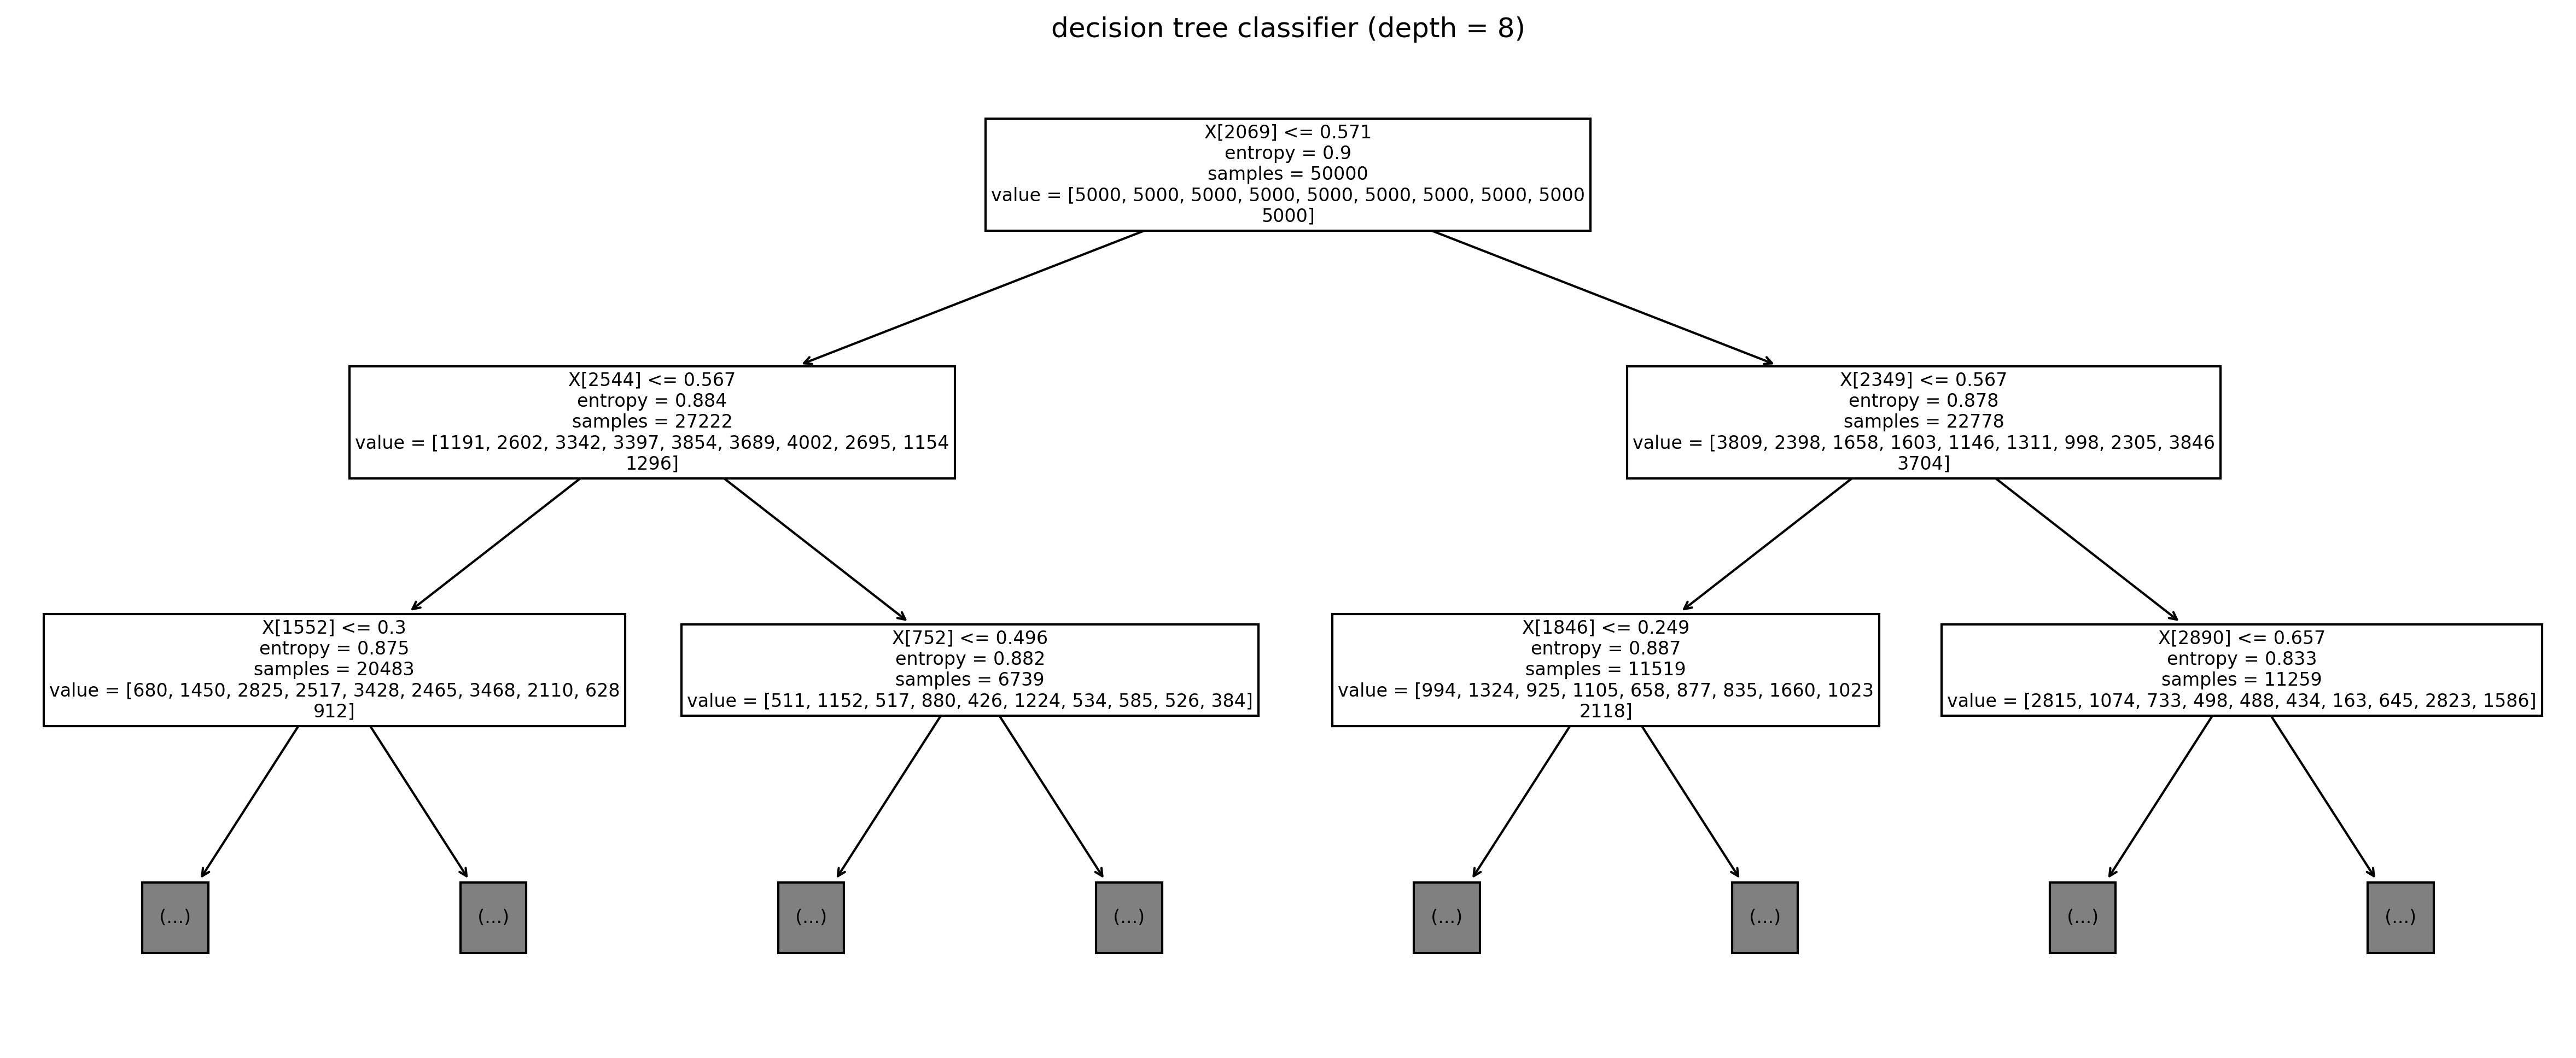

In [9]:
# retrieve the optimal value of max_depth
optimal_max_depth = gridcv_best_estimator.get_depth()

# plot the top 2 layers
top_layers = 2
plot_dtc(gridcv_best_estimator, tree_depth=optimal_max_depth, plot_depth=top_layers, save=True)

I will try to explain the plot by explaining one of the node. 

For example, I take the second layer leftmost node as an example:

```
    X[2544] <= 0.567
    entropy = 0.884
    samples = 27222
    values = [1191, 2602, 3397, 3854, 3689, 4002, 2695, 1154, 1296]
```

This snippet means:

1. Images whose the $2544^{th}$ feature is less or equal than 0.567, go in this node
2. The entropy of this node = 0.884
3. There are 27222 image samples in total which go in this node
4. The list indicates how many images for each class ('airliane', 'automobile', ...) go in this node


<div style="border-bottom: 3px solid black;"><div>

# 4. Train a convolutional neural network (CNN) using PyTorch to classify images on CIFAR10 datasets

## 4.1. Define the CNN model class

Our designed convolutional neural network architecture is inspired by **VGG Blocks** where the idea is first emerged from the Visual Geometry Group (VGG) at Oxford University. And the architecture was firstly described in the 2014 paper titled **"Very Deep Convolutional Networks for Large-Scale Image Recognition"**

We tuned the vanilla VGG Blocks by adding a few BatchNorm2d layers and Dropout layers for better normalization. And we did implemente 2 convolutional neural networks for normalization comparison purpose, one with 1 VGG Block with small p Dropout layer *(we named this convnet as Base-CNN in our paper)* and another one with 2 VGG Blocks with BatchNorm2d layers and meidum-size p Dropout layers in larger parameter $p$ *(we named this convnet as CNN-1 in our paper)*. We will compare these 2 models with their test accuracy and activation maximiation results in this and next section. 

We defined the first CNN with 1 VGG Block with Dropout layers as **class CNN1** *(Base-CNN in our paper)*, and defined the second CNN with 2 VGG Blocks with BatchNorm2d layers and Dropout layers as **class CNN2** *(CNN-1 in our paper)*.

**However**, in the final results comparison, class CNN2 as our final convolutional neural network architecture, has better normalization and test accuracy as well as activation images.

The reason why we use VGG architecture as our reference is that:

1. The architecture was an important milestone and was used broadly for computer vision and image recognition
2. The architecture is scalable and easy to implement and train in shorter time

*Reference and credits to VGG Block and paper:*

*1. [VGG Blocks](http://d2l.ai/chapter_convolutional-modern/vgg.html)*

*2. [Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition.](https://arxiv.org/pdf/1409.1556.pdf)*


In [52]:
# This is the CNN with 1 VGG Block and Dropout layer
class CNN1(torch.nn.Module):
    
    # This is the path where the model will be saved
    MODEL_PATH = './CNN_1_trained.pkl'
    
    # This neural network architecture is cited from VGG original paper
    def __init__(self):
        super(CNN1, self).__init__()
        
        # Convolutional layer arguments
        conv_filter_size = 3
        conv_layer_stride = 1
        conv_layer_padding = 1

        # MaxPooling layer arguments
        maxpool_filter_size = 2
        maxpool_layer_stride = 2
        maxpool_layer_padding = 0  # no padding
    
        # define the ConvNet
        self.model = torch.nn.Sequential(
            # VGG block
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=conv_filter_size, stride=conv_layer_stride, padding=conv_layer_padding),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=conv_filter_size, stride=conv_layer_stride, padding=conv_layer_padding),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=maxpool_filter_size, stride=maxpool_layer_stride),
            torch.nn.Dropout(p=0.1),
            # output size is 16 x 16 x 32

            torch.nn.Flatten(),
            torch.nn.Linear(in_features=16*16*32, out_features=128),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=128, out_features=10)
        )

    def forward(self, x):
        activation = self.model(x)
        soft = nn.Softmax(dim=1)
        prediction = soft(activation)
        return prediction
    
    def train(self, num_epoch=1, tag_epoch=1, batch_size=100, learning_rate=0.1):
        """
        Train the CNN model then save the model
        
        @param num_epoch    total number of epochs the model is going to run
        @param batch_size   after each batch_size, the model prints the accumulated loss
        """
        
        print('start training.')
        
        loss = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-3)
        
        # continue training on saved model
        if os.path.isfile(self.MODEL_PATH):
            self.model.load_state_dict(torch.load(self.MODEL_PATH))
            self.model.eval()
        
        # training for num_epoch epochs
        for epoch in range(num_epoch):
            
            # clear the loss
            epoch_loss = 0.0
            
            for i, data in enumerate(train_loader, 0):
                # get a batch_size of training samples and their labels
                inputs, labels = data
                
                # get the predictions
                outputs = self.model(inputs)
                
                # compute the loss
                l = loss(outputs, labels)
                
                # zero the gradients and backprop and step
                self.model.zero_grad()
                l.backward()
                optimizer.step()

                # accumulate the loss and print 
                epoch_loss += l.item()
                if i % batch_size == batch_size-1:
                    print('[epoch=%d, %5d batches] loss: %.3f' % (epoch + 1, i + 1, epoch_loss / batch_size))
                    epoch_loss = 0.0
    
        print('Finished Training')

        
    def test(self):
        """
        Evaluate the CNN
        Print test accuracy
        """
        
        # load the saved model
        if os.path.isfile(self.MODEL_PATH):
            self.model.load_state_dict(torch.load(self.MODEL_PATH))
            self.model.eval()
        
        # record total number of testing samples and total number of correctly labelled samples
        num_total = 0
        num_correct = 0
        
        for data in test_loader:
            # get a batch_size of testing samples and their labels
            images, labels = data
            
            # get the softmax results on the batch_size testing samples
            outputs = self.model(images)
            
            # get the maximum values and corresponding indices
            _, indices = torch.max(outputs.data, 1)
            
            # accumulate the total number of samples and number of correctly labelled samples
            num_total += labels.size(0)
            num_correct += (indices == labels).sum().item()
            
        print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * (num_correct / num_total)))

        
    def activation_maximization(self, image, target, labels, num_iter=1, learning_rate=0.2):
        """
        Perturb the image and try to maximize the target's neuron's activation
        
        @param image         : image tensor (shape [1, 3, 32, 32])
        @param target        : class target (e.g. tensor([2]) for 'bird' class)
        @param labels        : the label neuron which we want to maximize its activation
        @param num_iter      : number of perturb the image
        @param learning_rate : perturb degree
        
        @return return the final image that maximizes the target's neuron's activation
        
        """
        
        # load the trained model
        if os.path.isfile(self.MODEL_PATH):
            self.model.load_state_dict(torch.load(self.MODEL_PATH))
            self.model.eval()   
        
        # zero the gradients
        self.model.zero_grad()
        
        for i in range(num_iter):
            # get the activation results of 10 output neurons
            activations = self.model(image)
            
            # get the activation of the target class neuron
            target_activation = activations[0, target]
        
            # print the activation
#             print(labels[target] + ' activation (iter ' + str(i) + '):', target_activation)
        
            target_activation.backward()
            
            # update the image
            image.data += learning_rate * image.grad
            
            # zero the gradients
            image.grad.zero_()
        
        # return tuned image
        return image

In [53]:
# This is the CNN with 2 VGG Blocks, BatchNorm2d and Dropout layers
class CNN2(torch.nn.Module):
    
    # This is the path where the model will be saved
    MODEL_PATH = './CNN_2_trained.pkl'
    
    # This neural network architecture is cited from VGG original paper
    def __init__(self):
        super(CNN2, self).__init__()
        
        # Convolutional layer arguments
        conv_filter_size = 3
        conv_layer_stride = 1
        conv_layer_padding = 1

        # MaxPooling layer arguments
        maxpool_filter_size = 2
        maxpool_layer_stride = 2
        maxpool_layer_padding = 0  # no padding
    
        # define the ConvNet
        self.model = torch.nn.Sequential(
            
            # first VGG block
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=conv_filter_size, stride=conv_layer_stride, padding=conv_layer_padding),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=conv_filter_size, stride=conv_layer_stride, padding=conv_layer_padding),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=maxpool_filter_size, stride=maxpool_layer_stride),
            torch.nn.Dropout(p=0.5),
            # output size is 16 x 16 x 32
            
            # second VGG block
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=conv_filter_size, stride=conv_layer_stride, padding=conv_layer_padding),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=conv_filter_size, stride=conv_layer_stride, padding=conv_layer_padding),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=conv_filter_size, stride=conv_layer_stride, padding=conv_layer_padding),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=maxpool_filter_size, stride=maxpool_layer_stride),
            torch.nn.Dropout(p=0.5),
            # output size is 8 x 8 x 64
            
            # fully-connected layers
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=8*8*64, out_features=128),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=128, out_features=10)
        )

        
    def forward(self, x):
        activation = self.model(x)
        soft = nn.Softmax(dim=1)
        prediction = soft(activation)
        return prediction

    
    def train(self, num_epoch=1, batch_size=100, learning_rate=0.1):
        """
        Train the CNN model then save the model
        
        @param num_epoch    total number of epochs the model is going to run
        @param batch_size   after each batch_size, the model prints the accumulated loss
        """
        
        print('start training.')
        
        loss = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-3)
        
        # continue training on saved model
        if os.path.isfile(self.MODEL_PATH):
            self.model.load_state_dict(torch.load(self.MODEL_PATH))
            self.model.eval()
        
        # training for num_epoch epochs
        for epoch in range(num_epoch):
            
            # clear the loss
            epoch_loss = 0.0
            
            for i, data in enumerate(train_loader, 0):
                # get a batch_size of training samples and their labels
                inputs, labels = data
                
                # get the predictions
                outputs = self.model(inputs)
                
                # compute the loss
                l = loss(outputs, labels)
                
                # zero the gradients and backprop and step
                self.model.zero_grad()
                l.backward()
                optimizer.step()

                # accumulate the loss and print 
                epoch_loss += l.item()
                if i % batch_size == batch_size-1:
                    print('[epoch=%d, %5d batches] loss: %.3f' % (epoch + 1, i + 1, epoch_loss / batch_size))
                    epoch_loss = 0.0
    
        print('Finished Training')

    def test(self):
        """
        Evaluate the CNN
        Print test accuracy
        """
        # load the saved model
        if os.path.isfile(self.MODEL_PATH):
            self.model.load_state_dict(torch.load(self.MODEL_PATH))
            self.model.eval()
        
        # record total number of testing samples and total number of correctly labelled samples
        num_total = 0
        num_correct = 0
        
        for data in test_loader:
            # get a batch_size of testing samples and their labels
            images, labels = data
            
            # get the softmax results on the batch_size testing samples
            outputs = self.model(images)
            
            # get the maximum values and corresponding indices
            _, indices = torch.max(outputs.data, 1)
            
            # accumulate the total number of samples and number of correctly labelled samples
            num_total += labels.size(0)
            num_correct += (indices == labels).sum().item()
            
        print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * (num_correct / num_total)))

        
    def activation_maximization(self, image, target, labels, num_iter=1, learning_rate=0.2):
        """
        Perturb the image and try to maximize the target's neuron's activation
        
        @param image         : image tensor (shape [1, 3, 32, 32])
        @param target        : class target (e.g. tensor([2]) for 'bird' class)
        @param labels        : the label neuron which we want to maximize its activation
        @param num_iter      : number of perturb the image
        @param learning_rate : perturb degree
        
        @return return the final image that maximizes the target's neuron's activation
        
        """
        
        # load the trained model
        if os.path.isfile(self.MODEL_PATH):
            self.model.load_state_dict(torch.load(self.MODEL_PATH))
            self.model.eval()   
        
        # zero the gradients
        self.model.zero_grad()
        
        for i in range(num_iter):
            # get the activation results of 10 output neurons
            activations = self.model(image)
            
            # get the activation of the target class neuron
            target_activation = activations[0, target]
            
            # print the activation
#             print(labels[target] + ' activation (iter ' + str(i) + '):', target_activation)

            target_activation.backward()
            
            # update the image
            image.data += learning_rate * image.grad
            
            # zero the gradients
            image.grad.zero_()
        
        # return tuned image
        return image

## 4.2 Train the model

### 4.2.1 Define the CNN models

You can redefine the model by running the cell below.

In [54]:
cnn1 = CNN1()    # (Base-CNN in our paper)
cnn2 = CNN2()    # (CNN-1 in our paper)

### 4.2.2 Strategies and training for cnn1 and cnn2

We first train both 2 models in `20 epochs`, and we change the `learning_rate` during training, whereas we maintain the `momentum=0.9` and `weight_decay=1e-3` the same.

We found that our 2 models learned slowly (or rarely) when the $learning\_rate \geq 0.01$. So here is our training strategy:

* `learning_rate=0.01` during epoch `1-5`
* `learning_rate=0.005` during epoch `6-10`
* `learning_rate=0.001` during epoch `11-15`
* `learning_rate=0.0005` during epoch `16-20`

For the model CNN2 **only**, since we want a better results, we will add 10 more epochs in the end, the strategy is shown below:

* `learning_rate=0.0001` during epoch `21-25`
* `learning_rate=0.00005` during epoch `26-27`
* `learning_rate=0.00001` during epoch `28-30`

**Attention!**

1. Before running the 2 cells just below to train cnn1 and cnn2, **if you want to re-train the model from zero, instead of continuing training based on the model that we already trained after epochs**, (which is a bit unreasonable since the model has already been finely tuned), **you could go back to section 4.1 and comment the code snippet below in *train()* method in *class CNN1* AND in *class CNN2* defined in section 4.1:**

```
    # continue training on saved model
    if os.path.isfile(self.MODEL_PATH):
        self.model.load_state_dict(torch.load(self.MODEL_PATH))
        self.model.eval()
```


   then redefine the models by running section 4.2.1 and run the 2 cells below to start training cnn1 and cnn2.


2. For training cnn1 from zero, it may need around **40 minutes** on lab Linux environment. However, our trained model *CNN_1_trained.pkl* has been placed in the same folder as this notebook. You can jump to section 4.4 to evaluate on it.
3. For training cnn2 from zero, it may need around **120 minutes** on lab Linux environment. However, our trained model *CNN_2_trained.pkl* has been placed in the same folder as this notebook. You can jump to section 4.4 to evaluate on it.



In [21]:
# train the model cnn1
cnn1.train(num_epoch=5, learning_rate=0.01)
cnn1.train(num_epoch=5, learning_rate=0.005)
cnn1.train(num_epoch=5, learning_rate=0.001)
cnn1.train(num_epoch=5, learning_rate=0.0005)

start training.
[epoch=1,   100 batches] loss: 0.174
[epoch=1,   200 batches] loss: 0.174
[epoch=1,   300 batches] loss: 0.158
[epoch=1,   400 batches] loss: 0.144
[epoch=1,   500 batches] loss: 0.153
[epoch=1,   600 batches] loss: 0.152
[epoch=1,   700 batches] loss: 0.143
[epoch=1,   800 batches] loss: 0.183
[epoch=1,   900 batches] loss: 0.172
[epoch=1,  1000 batches] loss: 0.188
[epoch=1,  1100 batches] loss: 0.147
[epoch=1,  1200 batches] loss: 0.163
[epoch=1,  1300 batches] loss: 0.184
[epoch=1,  1400 batches] loss: 0.198
[epoch=1,  1500 batches] loss: 0.131
[epoch=1,  1600 batches] loss: 0.194
[epoch=1,  1700 batches] loss: 0.128
[epoch=1,  1800 batches] loss: 0.202
[epoch=1,  1900 batches] loss: 0.197
[epoch=1,  2000 batches] loss: 0.184
[epoch=1,  2100 batches] loss: 0.152
[epoch=1,  2200 batches] loss: 0.183
[epoch=1,  2300 batches] loss: 0.220
[epoch=1,  2400 batches] loss: 0.178
[epoch=1,  2500 batches] loss: 0.168
[epoch=1,  2600 batches] loss: 0.228
[epoch=1,  2700 batche

*Hint before training cnn2 from zero:*

Training *cnn2* was a little tricky. While we were training *cnn2*, we sometimes fall into local minimum during the first 5 epochs (with $learning\_rate=0.01$) and stuck around $loss: 2.300$ then never drop. When we encountered this issue, we would choose to skip the first 5 epochs and start training from $learning\_rate=0.005$. By doing so, we often could resolve the issue.

So, the first 5 epochs have already been commented, however you can un-comment it and try, **if you stuck around $loss: 2.300$ after 2 epochs, please try to skip the first line and start training from $learning\_rate=0.005$**. After the first epoch, if you get around $loss: 1.615$, it would be fine.

In [22]:
# train the model cnn2
# cnn2.train(num_epoch=5, learning_rate=0.01)   # Note: if you stuck around loss:2.300 after 2 epochs, try to comment this line
cnn2.train(num_epoch=5, learning_rate=0.005)
cnn2.train(num_epoch=5, learning_rate=0.001)
cnn2.train(num_epoch=5, learning_rate=0.0005)
cnn2.train(num_epoch=5, learning_rate=0.0001)
cnn2.train(num_epoch=2, learning_rate=0.00005)
cnn2.train(num_epoch=3, learning_rate=0.00001)

start training.
[epoch=1,   100 batches] loss: 0.360
[epoch=1,   200 batches] loss: 0.400
[epoch=1,   300 batches] loss: 0.363
[epoch=1,   400 batches] loss: 0.369
[epoch=1,   500 batches] loss: 0.464
[epoch=1,   600 batches] loss: 0.354
[epoch=1,   700 batches] loss: 0.398
[epoch=1,   800 batches] loss: 0.433
[epoch=1,   900 batches] loss: 0.394
[epoch=1,  1000 batches] loss: 0.383
[epoch=1,  1100 batches] loss: 0.439
[epoch=1,  1200 batches] loss: 0.308
[epoch=1,  1300 batches] loss: 0.386
[epoch=1,  1400 batches] loss: 0.318
[epoch=1,  1500 batches] loss: 0.332
[epoch=1,  1600 batches] loss: 0.347
[epoch=1,  1700 batches] loss: 0.346
[epoch=1,  1800 batches] loss: 0.353
[epoch=1,  1900 batches] loss: 0.401
[epoch=1,  2000 batches] loss: 0.360
[epoch=1,  2100 batches] loss: 0.400
[epoch=1,  2200 batches] loss: 0.414
[epoch=1,  2300 batches] loss: 0.426
[epoch=1,  2400 batches] loss: 0.381
[epoch=1,  2500 batches] loss: 0.450
[epoch=1,  2600 batches] loss: 0.348
[epoch=1,  2700 batche

## 4.3 Save the model

Save the trained *cnn1* and *cnn2* on the current folder as the notebook, whose names are 'CNN_1_trained.pkl' and 'CNN_2_trained.pkl'.

In [21]:
# save the model cnn1
torch.save(cnn1.model.state_dict(), cnn1.MODEL_PATH)

In [ ]:
# save the model cnn2
torch.save(cnn2.model.state_dict(), cnn2.MODEL_PATH)

## 4.4 Testing Accuracy

**These are our recorded results for cnn1:**


| epoch # | train loss | test accuracy | learning_rate |
| --- | --- | --- | --- |
| 1   | 1.664 | 38.40% | 0.01 |
| 2   | 1.569 | 47.49% | 0.01 |
| 3   | 1.499 | 44.94% | 0.01 |
| 4   | 1.428 | 51.29% | 0.01 |
| 5   | 1.465 | 49.65% | 0.01 |
| 6   | 1.152 | 55.19% | 0.005 |
| 7   | 1.078 | 58.71% | 0.005 |
| 8   | 1.054 | 57.20% | 0.005 |
| 9   | 1.141 | 57.90% | 0.005 |
| 10  | 1.020 | 56.55% | 0.005 |
| 11  | 0.622 | 65.19% | 0.001 |
| 12  | 0.570 | 65.60% | 0.001 |
| 13  | 0.460 | 65.52% | 0.001 |
| 14  | 0.439 | 64.61% | 0.001 |
| 15  | 0.351 | 63.65% | 0.001 |
| 16  | 0.282 | 65.43% | 0.0005 |
| 17  | 0.237 | 65.65% | 0.0005 |
| 18  | 0.228 | 65.26% | 0.0005 |
| 19  | 0.224 | 65.39% | 0.0005 |
| 20  | 0.238 | 64.35% | 0.0005 |


**Attention:**

1. If you load the our pre-trained model, then:

Due to the reason that we use *RandomErasing* in *Section 1. load_CIFAR10 function*, so the test accuracy here will not be fixed. You may get different accuracy from our recorded results when you run the cell below. But the accuracy should be close to our results in the table within $1\%$.


2. If you train the cnn1 from zero, then:

You may get different accuracy because of randomly initial weights. We re-trained the $cnn1$ twice, and got accuracy of $64.35\%$ and $65.64\%$ respectively.

In [56]:
# evaluate the model cnn1
test_model_cnn1 = CNN1()
test_model_cnn1.test()

Accuracy of the network on the 10000 test images: 65.15 %


**These are our recorded results for cnn2:**

| epoch # | train loss | test accuracy | learning_rate |
| --- | --- | --- | --- |
| 1   | 1.725 | 43.12% | 0.01 |
| 2   | 1.287 | 52.86% | 0.01 |
| 3   | 1.339 | 55.93% | 0.01 |
| 4   | 1.187 | 59.50% | 0.01 |
| 5   | 1.175 | 52.92% | 0.01 |
| 6   | 1.050 | 64.33% | 0.005 |
| 7   | 1.029 | 62.76% | 0.005 |
| 8   | 1.000 | 65.75% | 0.005 |
| 9   | 0.981 | 62.41% | 0.005 |
| 10  | 1.057 | 64.90% | 0.005 |
| 11  | 0.615 | 72.41% | 0.001 |
| 12  | 0.696 | 72.21% | 0.001 |
| 13  | 0.639 | 73.70% | 0.001 |
| 14  | 0.610 | 73.21% | 0.001 |
| 15  | 0.639 | 74.25% | 0.001 |
| 16  | 0.599 | 74.85% | 0.0005 |
| 17  | 0.699 | 74.94% | 0.0005 |
| 18  | 0.553 | 74.50% | 0.0005 |
| 19  | 0.529 | 75.15% | 0.0005 |
| 20  | 0.566 | 74.57% | 0.0005 |
| 21  | 0.434 | 77.22% | 0.0001 |
| 22  | 0.438 | 76.59% | 0.0001 |
| 23  | 0.471 | 77.01% | 0.0001 |
| 24  | 0.413 | 76.83% | 0.0001 |
| 25  | 0.445 | 77.01% | 0.0001 |
| 26  | 0.428 | 76.80% | 0.00005 |
| 27  | 0.360 | 77.04% | 0.00005 |
| 28  | 0.360 | 76.95% | 0.00001 |
| 29  | 0.405 | 76.92% | 0.00001 |
| 30  | 0.403 | 77.30% | 0.00001 |


**Attention:**

1. If you load the our pre-trained model, then:

Due to the reason that we use *RandomErasing* in *Section 1. load_CIFAR10 function*, so the test accuracy here will not be fixed. You may get different accuracy from our recorded results when you run the cell below. But the accuracy should be close to the results in the table within $1\%$.

2. If you train the cnn2 from zero, then:

You may get different accuracy because of randomly initial weights. We re-trained the $cnn2$ once, and got accuracy of $77.30\%$.

In [29]:
# evaluate the model cnn2
test_model_cnn2 = CNN2()
test_model_cnn2.test()

Accuracy of the network on the 10000 test images: 77.33 %


# 5. Interpret the CNN by using the 'activation maximization' technique

## 5.1 Define an image loader and an inverse_normalize transformation

In [57]:
# Load the image and normalize to [-1, 1]
loader = transforms.Compose([
    transforms.ToTensor(),
    
    # ((mean_R, mean_G, mean_B), (std_R, std_G, std_B))
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


# De-normalize a [-1, 1] tensor to a [0, 1] tensor (for showing image)
inv_normalize = transforms.Compose([
    # ((mean_R, mean_G, mean_B), (std_R, std_G, std_B))
    transforms.Normalize(mean=(-1, -1, -1), std=(2, 2, 2))
])

## 5.2 Define functions for activation maximization

* **image_loader**: load a RGB image from the path and return a tensor
* **inverse_normalize**: inverse normalize from [-1, 1] tensor to [0, 1] tensor (For showing image)
* **imshow**: show an image tensor

In [58]:
def image_loader(image_name):
    """
    load the image under './image' folder
    
    @param image_name : image file name
    """
    image = Image.open('./image/' + image_name).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image


def inverse_normalize(image_tensor):
    """
    Inverse normalize a [-1, 1] image tensor to [0, 1]
    
    @param image_tensor: [-1, 1] tensor
    
    @return a [0, 1] tensor
    """
    return inv_normalize(image_tensor[0])

def imshow(image_tensor, title='activation image'):
    """
    Show a [-1, 1] tensor (shape [1, 3, 32, 32])
    
    @param image_tensor: a normalized [-1, 1] tensor
    @param title       : plot title
    """
    # transform from (# of Channel, Width, Height) to (Width, Height, # of Channel)
    image_tensor = image_tensor.permute(1, 2, 0)
    
    # convert the tensor to numpy
    np_image = image_tensor.detach().numpy().astype(np.float)

    # show the image
    plt.imshow(np_image.reshape(32, 32, 3))
    
    # show the title
    plt.title(title)

## 5.3 Load the initial grey image

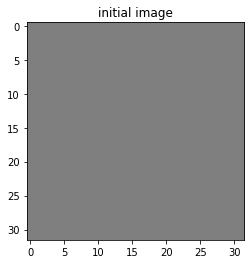

In [59]:
def load_initial_image(image_name='activation_base.jpg'):
    # load the initial grey image
    image_tensor = image_loader(image_name)

    # set requires_grad=True in order to compute the gradient of a particular class activation with respect to all image pixels
    image_tensor.requires_grad=True

    return image_tensor


# retrieve the image tensor
image_tensor = load_initial_image()

# print the loaded image
# first, inverse normalization
output = inverse_normalize(image_tensor)
## second, show the image
imshow(output, title='initial image')

## 5.4 Retrieve the CIFAR10 labels

In [60]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

labels = load_label_names()

## 5.5 Perturb the grey image to maximize class activation and show result images

### 5.5.1 Define 10 targets for 10 classes

In [61]:
# define the targets
target_airplane   = torch.max(torch.tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 1)[1]
target_automobile = torch.max(torch.tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]), 1)[1]
target_bird       = torch.max(torch.tensor([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]]), 1)[1]
target_cat        = torch.max(torch.tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]), 1)[1]
target_deer       = torch.max(torch.tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]), 1)[1]
target_dog        = torch.max(torch.tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]), 1)[1]
target_frog       = torch.max(torch.tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]]), 1)[1]
target_horse      = torch.max(torch.tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]), 1)[1]
target_ship       = torch.max(torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]), 1)[1]
target_truck      = torch.max(torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]), 1)[1]
targets = []
targets.append(target_airplane)
targets.append(target_automobile)
targets.append(target_bird)
targets.append(target_cat)
targets.append(target_deer)
targets.append(target_dog)
targets.append(target_frog)
targets.append(target_horse)
targets.append(target_ship)
targets.append(target_truck)

### 5.5.2 Show activation images on cnn1 (1 VGG Block + Dropout layer + FC layers)

Note: As the $num\_iter$ and $learning\_rate$ increases, there may appear warnings:

```
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
```


The activation images for cnn1 *(Base-CNN in our paper)* are bad due to the low test accuracy. You can compare the activation maximization results here with section 5.5.3 and section 5.6.2.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


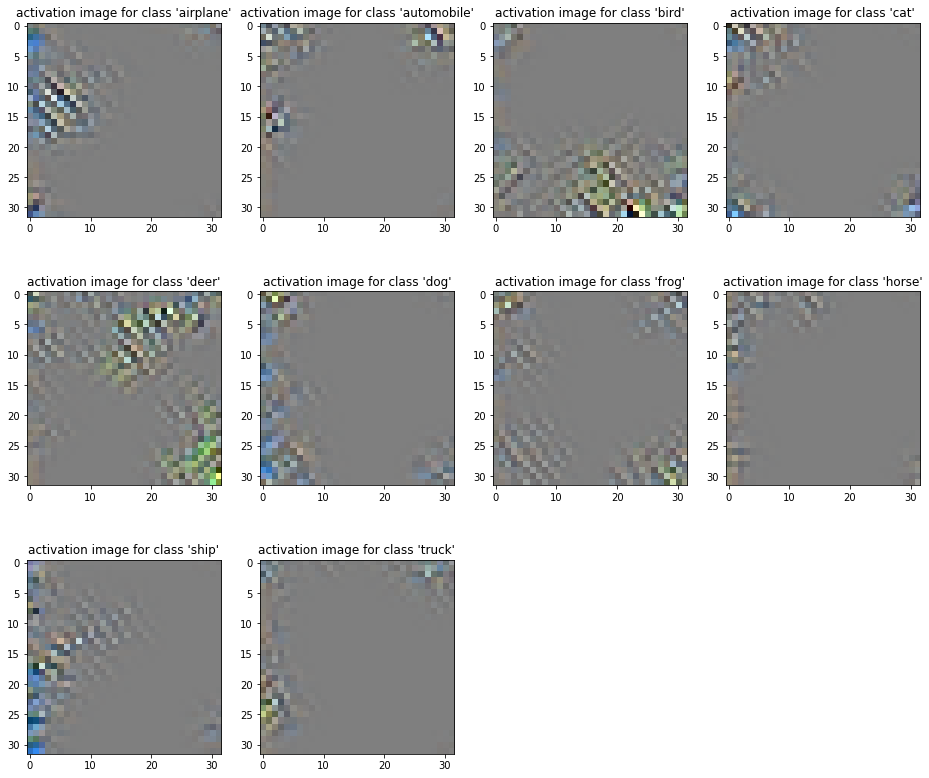

In [66]:
# define a CNN1 model
cnn1 = CNN1()

# defome the arguments for activation_maximization method
num_iter = 60
learning_rate = 0.02

fig = plt.figure(figsize=(16, 14))
rows = 3
columns = 4
idx = 1

for target in targets:

    # get a new initial grey image tensor
    image_tensor = load_initial_image()
    
    # perturb the grey image and try to maximize the bird neuron activation
    tuned_image = cnn1.activation_maximization(
        image=image_tensor,
        target=target,
        labels=labels,
        num_iter=num_iter,
        learning_rate=learning_rate)

    # show the class activation map
    fig.add_subplot(rows, columns, idx)
    show_image = inverse_normalize(tuned_image)
    imshow(show_image, title='activation image for class \'' + labels[target] + '\'')
    idx += 1

### 5.5.3 Show activation images on cnn2 (2 VGG Block + BatchNorm2d layers + Dropout layers + FC layers)

Note: As the $num\_iter$ and $learning\_rate$ increases, there may appear warnings:

```
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
```


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


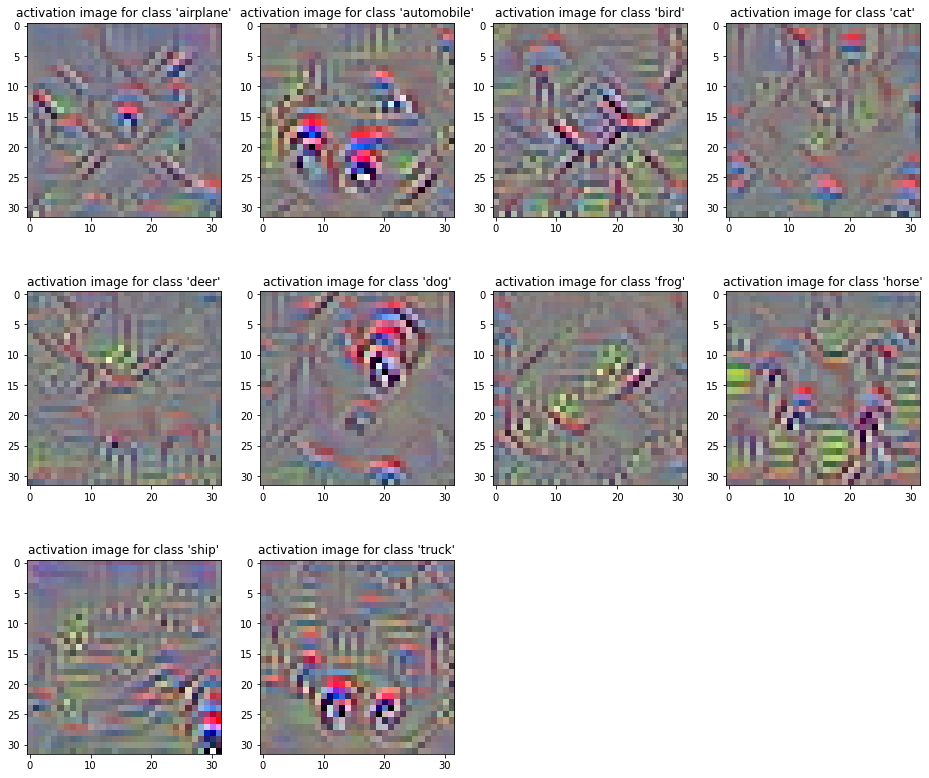

In [67]:
# define a CNN2 model
cnn2 = CNN2()

# defome the arguments for activation_maximization method
num_iter = 200
learning_rate = 0.015

fig = plt.figure(figsize=(16, 14))
rows = 3
columns = 4
idx = 1

for target in targets:

    # get a new initial grey image tensor
    image_tensor = load_initial_image()
    
    # perturb the grey image and try to maximize the bird neuron activation
    tuned_image = cnn2.activation_maximization(
        image=image_tensor,
        target=target,
        labels=labels,
        num_iter=num_iter,
        learning_rate=learning_rate)

    # show the class activation map
    fig.add_subplot(rows, columns, idx)
    show_image = inverse_normalize(tuned_image)
    imshow(show_image, title='activation image for class \'' + labels[target] + '\'')
    idx += 1

The activation images for cnn2 are fair good, however, we will show our best activation images in the following sections.


### Comparison with our best_cnn's activation maps:

You can compare the activation maps here with our best model's in section 5.6.2 by running the following sections

## 5.6 Load our best model and plot the activation maps

In our CNN expriments, we trained another CNN classifier *(we call this CNN-2 in our paper)* on the training images **without** applying data augmentation technique *torchchvision.transforms.RandomErasing* which is described in project guideline section 3. Convolutional neural network classifier part:

```
If necessary, you can use techniques like data augmentation (the torchvision package can help with that) in order to achieve higher accuracy.
```

And that CNN-2 model uses the same CNN architecture as *class CNN2* (in our paper, called CNN-1) and achieved the highest test accuracy of $81.40\%$ than the *class CNN2* which achieves $77.30\%$ over our CNN expriments.

We intend to load the best model to show better activation maps so that you can have a comparison view between 3 groups of activation maps.

### 5.6.1 Redefine the transformation during loading dataset (without applying torchchvision.transforms.RandomErasing)

Note: you can compare this function with section 1. The only difference is that we remove the code snippet in transform:

```
    # random erasing
    transforms.RandomErasing(),
```

Note that, the cell below will **overwrite** the $train\_loader$ and $test\_loader$ with randomly erasing defined in section 1.

In [68]:
def load_CIFAR10(root='datasets/'):
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        
        # normalize values from [0, 1] to [-1, 1]
        transforms.Normalize(
            mean=(0.5, 0.5, 0.5), 
            std=(0.5, 0.5, 0.5))
    ])
    
    # read the training set by batches
    train_set = CIFAR10(root=root, train=True, download=False, transform=transform)
    train_loader = DataLoader(train_set, batch_size=5, shuffle=True, num_workers=2)
    
    # read the testing set by batches
    test_set = CIFAR10(root=root, train=False, download=False, transform=transform)
    test_loader = DataLoader(test_set, batch_size=5, shuffle=False, num_workers=2)
    
    return train_loader, test_loader


# Get the train_loader and test_loader
train_loader, test_loader = load_CIFAR10()


### 5.6.2 Redefine the Best_CNN model class

Note: you can compare *this class* with *class CNN2* in section 4.1. *class Best_CNN* has the same architecture as *class CNN2*.

In [69]:
class Best_CNN(torch.nn.Module):
    
    MODEL_PATH = './Best_CNN.pkl'
    
    # This neural network architecture is cited from VGG original paper
    def __init__(self):
        super(Best_CNN, self).__init__()
        
        conv_filter_size = 3
        conv_layer_stride = 1
        conv_layer_padding = 1

        maxpool_filter_size = 2
        maxpool_layer_stride = 2
        maxpool_layer_padding = 0  # no padding
    
        self.model = torch.nn.Sequential(
            # first VGG block
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=conv_filter_size, stride=conv_layer_stride, padding=conv_layer_padding),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=conv_filter_size, stride=conv_layer_stride, padding=conv_layer_padding),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=maxpool_filter_size, stride=maxpool_layer_stride),
            torch.nn.Dropout(p=0.5),
            # output size is 16 x 16 x 32
            
            # second VGG block
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=conv_filter_size, stride=conv_layer_stride, padding=conv_layer_padding),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=conv_filter_size, stride=conv_layer_stride, padding=conv_layer_padding),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=conv_filter_size, stride=conv_layer_stride, padding=conv_layer_padding),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=maxpool_filter_size, stride=maxpool_layer_stride),
            torch.nn.Dropout(p=0.5),
            # output size is 8 x 8 x 64
            
            # fully-connected layers
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=8*8*64, out_features=128),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=128, out_features=10)
        )

        
    def forward(self, x):
        activation = self.model(x)
        soft = nn.Softmax(dim=1)
        prediction = soft(activation)
        return prediction

    
    def train(self, num_epoch=1, batch_size=100):
        """
        Train the CNN model then save the model
        
        @param num_epoch    total number of epoches the model is going to run
        @param batch_size   after each batch_size, the model prints the accumulated loss
        """
        
        print('start training.')
        
        loss = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.000005, momentum=0.9, weight_decay=1e-3)
        
        # continue training on saved model
        if os.path.isfile(self.MODEL_PATH):
            self.model.load_state_dict(torch.load(self.MODEL_PATH))
            self.model.eval()
        
        # training for num_epoch epoches
        for epoch in range(num_epoch):
            # accumulated loss over 1 batch size
            running_loss = 0.0
            
            for i, data in enumerate(train_loader, 0):
                # get a batch_size of training samples and their labels
                inputs, labels = data
                
                # get the predictions
                outputs = self.model(inputs)
                
                # compute the loss
                l = loss(outputs, labels)
                
                # 
                self.model.zero_grad()
                l.backward()
                optimizer.step()

                # accmulate the loss
                running_loss += l.item()
                if i % batch_size == batch_size-1:
                    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / batch_size))
                    running_loss = 0.0
    
        print('Finished Training')

    def test(self):
        # load the saved model
        self.model.load_state_dict(torch.load(self.MODEL_PATH))
        self.model.eval()
        
        # record total number of testing samples and total number of correctly labelled samples
        num_total = 0
        num_correct = 0
        
        for data in test_loader:
            # get a batch_size of testing samples and their labels
            images, labels = data
            
            # get the softmax results on the batch_size testing samples
            outputs = self.model(images)
            
            # get the maximum values and corresponding indices
            _, indices = torch.max(outputs.data, 1)
            
            # accumulate the total number of samples and number of correctly labelled samples
            num_total += labels.size(0)
            num_correct += (indices == labels).sum().item()
            
        print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * (num_correct / num_total)))

        
    def activation_maximization(self, image, target, labels, num_iter=1, learning_rate=0.2):
        """
        Perturb the image and try to maximize the target's neuron's activation
        
        @param image         : image tensor (shape [1, 3, 32, 32])
        @param target        : class target (e.g. tensor([2]) for 'bird' class)
        @param labels        : the label neuron which we want to maximize its activation
        @param num_iter      : number of perturb the image
        @param learning_rate : perturb degree
        
        @return return the final image that maximizes the target's neuron's activation
        
        """
        
        # load the trained model
        if os.path.isfile(self.MODEL_PATH):
            self.model.load_state_dict(torch.load(self.MODEL_PATH))
            self.model.eval()   
        
        # zero the gradients
        self.model.zero_grad()
        
        for i in range(num_iter):
            # get the activation results of 10 output neurons
            activations = self.model(image)
            
            target_activation = activations[0, target]
            
            # print the activation
#             print(labels[target] + ' activation (iter ' + str(i) + '):', target_activation)

            target_activation.backward()
            
            # update the image
            image.data += learning_rate * image.grad
            
            # zero the gradients
            image.grad.zero_()
        
        # return tuned image
        return image

### 5.6.3 Define a model and evaluate on the test images

Expected test accuracy: $81.40\%$

In [70]:
# define a Best_CNN model
best_cnn = Best_CNN()

# print the test accuracy
best_cnn.test()

Accuracy of the network on the 10000 test images: 81.40 %


### 5.6.2 Plot the activation maps

You can compare with results in section 5.5.3 and section 5.5.2. The results in this section would be better and clearer :D

Note: As the $num\_iter$ and $learning\_rate$ increases, there may appear warnings:

```
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
```


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


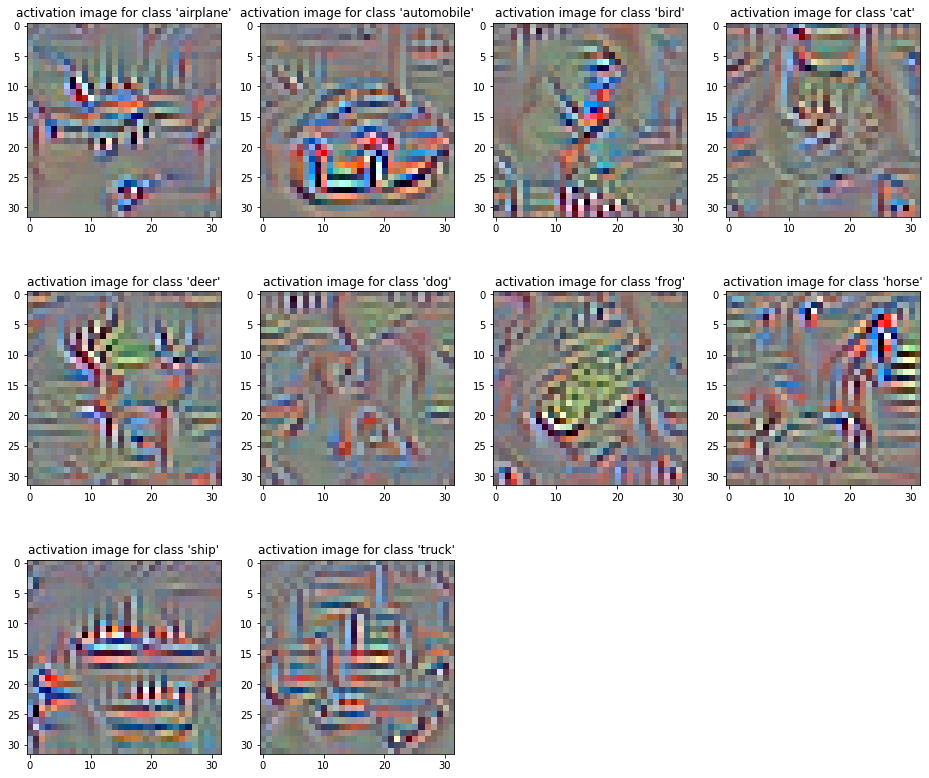

In [71]:
# defome the arguments for activation_maximization method
num_iter = 100
learning_rate = 0.015

fig = plt.figure(figsize=(16, 14))
rows = 3
columns = 4
idx = 1

for target in targets:

    # get a new initial grey image tensor
    image_tensor = load_initial_image()
    
    # perturb the grey image and try to maximize the bird neuron activation
    tuned_image = best_cnn.activation_maximization(
        image=image_tensor,
        target=target,
        labels=labels,
        num_iter=num_iter,
        learning_rate=learning_rate)

    # show the class activation map
    fig.add_subplot(rows, columns, idx)
    show_image = inverse_normalize(tuned_image)
    imshow(show_image, title='activation image for class \'' + labels[target] + '\'')
    idx += 1

# Project Master Script 2  END

# Thanks for reading!

<div style="border-bottom: 3px solid black;"><div>